In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models



In [ ]:
REBUILD_DATA = True

class TramisuVSBaklava():
    IMG_SIZE = 50 
    TRAMISU = "/content/gdrive/MyDrive/images/tramisu"
    BAKLAVA = "/content/gdrive/MyDrive/images/baklava"
    LABELS = {TRAMISU : 0, BAKLAVA : 1}

    training_data = []
    tramisucount = 0
    baklavacount = 0

    def make_training_data(self):
      for label in self.LABELS:
        print(label)
        for f in tqdm(os.listdir(label)):
          if "jpg" in f: 
            try:
              path = os.path.join(label, f)
              img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
              img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
              self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])

              if label == self.TRAMISU:
                self.tramisucount += 1
              elif label == self.BAKLAVA:
                self.baklavacount += 1
            except Exception as e:
              pass
      np.random.shuffle(self.training_data)
      print("Tramisu: ", tramisuvbaklava.tramisucount)
      print("Baklava: ", tramisuvbaklava.baklavacount)
      np.save("training_data.npy", self.training_data)


if REBUILD_DATA:
  tramisuvbaklava = TramisuVSBaklava()
  tramisuvbaklava.make_training_data()
  
training_data = np.load("training_data.npy", allow_pickle = True)

/content/gdrive/MyDrive/images/tramisu


100%|██████████| 300/300 [00:04<00:00, 66.44it/s] 


/content/gdrive/MyDrive/images/baklava


100%|██████████| 300/300 [00:04<00:00, 65.37it/s] 

Tramisu:  300
Baklava:  300



/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [ ]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 32, 5)
    self.conv2 = nn.Conv2d(32, 64, 5)
    self.conv3 = nn.Conv2d(64, 128, 5)

    x = torch.randn(50, 50).view(-1, 1, 50, 50)
    self._to_linear = None
    self.convs(x)
    self.fc1 = nn.Linear(self._to_linear ,512)
    self.fc2 = nn.Linear(512, 2)
    
  def convs(self, x):
    #print(x.shape)
    x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
    #print(x.shape)
    x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
    #print(x.shape)
    x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
    #print(x.shape)
    if self._to_linear is None:
      self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
    return x
  def forward(self, x):
    x = self.convs(x)
    x = x.view(-1, self._to_linear)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return F.softmax(x, dim = 1)

net = Net()
print(net)

optimizer = optim.Adam(net.parameters(), lr = 0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
#print(val_size)

train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

BATCH_SIZE = 20
EPOCHS = 3
output = []

def train(net):
  for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
      
      batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
      #print(batch_X.shape)
      batch_y = train_y[i:i+BATCH_SIZE]
      #print(batch_y.shape)
      net.zero_grad()
      outputs = net(batch_X)
      loss = loss_function(outputs, batch_y)
      loss.backward()
      optimizer.step()
      if epoch == EPOCHS-1:
        output.append(outputs)
      #print(outputs.shape)
      #print(outputs)
    print(f"Epoch: {epoch}. Loss: {loss}")

def test(net):
  correct = 0 
  total = 0
  with torch.no_grad():
    for i in tqdm(range(len(test_X))):
      real_class = torch.argmax(test_y[i])
      net_out = net(test_X[i].view(-1, 1, 50, 50))[0]
      predicted_class = torch.argmax(net_out)
      if predicted_class == real_class:
        correct += 1
      total += 1
  print("Accuracy:", round(correct/total,3))


Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


In [ ]:
train(net)


100%|██████████| 27/27 [00:01<00:00, 13.67it/s]


Epoch: 0. Loss: 0.15145185589790344


100%|██████████| 27/27 [00:01<00:00, 13.91it/s]


Epoch: 1. Loss: 0.15715418756008148


100%|██████████| 27/27 [00:01<00:00, 13.66it/s]

Epoch: 2. Loss: 0.1629393994808197


In [ ]:
length = len(output)
i = 0
j = 0
out1 = []
for i in range(27):
  for j in range(BATCH_SIZE):
    out1.append(output[i][j])
print(len(out1))

540


In [ ]:
for i in range(len(out1)):
  if out1[i][0] > out1[i][1]:
    out1[i][0]=1
    out1[i][1]=0
  else:
    out1[i][0]=0
    out1[i][1]=1
  

tensor([1., 0.], grad_fn=<AsStridedBackward0>)


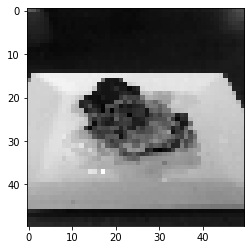

In [ ]:
plt.imshow(train_X[6], cmap = 'gray')
print(out1[6])


In [ ]:
test(net)

100%|██████████| 60/60 [00:00<00:00, 570.17it/s]

Accuracy: 0.783


In [ ]:
model = models.vgg16(pretrained=True)
torch.save(model.state_dict(), 'model_weights.pth')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
model = models.vgg16() # we do not specify pretrained=True, i.e. do not load default weights
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

This section is copying the model with weights and deletes the last fully connected layer.

In [ ]:
copymodel = model
copymodel.classifier = nn.Sequential(*list(copymodel.classifier.children())[:-3])
copymodel.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:


REBUILD_DATA = True

class TestData():
    IMG_SIZE = 50 
    TEST = '/content/gdrive/MyDrive/images/test'
    LABELS = {TEST : 0}
    test_data = []
    testcount = 0

    def make_test_data(self):
      for label in self.LABELS:
        print(label)
        for f in tqdm(os.listdir(label)):
          if "jpg" in f: 
            try:
              path = os.path.join(label, f)
              img = cv2.imread(path)
              img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
              self.test_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])
              if label == self.TEST:
                self.testcount += 1
            except Exception as e:
              pass
      print("Tramisu: ", testdata_.testcount)
      np.save("test_data.npy", self.test_data)


if REBUILD_DATA:
  testdata_ = TestData()
  testdata_.make_test_data()
  
test_data = np.load("test_data.npy", allow_pickle = True)


/content/gdrive/MyDrive/images/test


100%|██████████| 100/100 [00:02<00:00, 47.07it/s]

Tramisu:  100



/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [ ]:
REBUILD_DATA = True

class baklavaTestData():
    IMG_SIZE = 50 
    BAKLAVATEST = '/content/gdrive/MyDrive/images/baklavatest'
    LABELS = {BAKLAVATEST : 0}
    Btest_data = []
    Btestcount = 0

    def make_baklava_data(self):
      for label in self.LABELS:
        print(label)
        for f in tqdm(os.listdir(label)):
          if "jpg" in f: 
            try:
              path = os.path.join(label, f)
              img = cv2.imread(path)
              img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
              self.Btest_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])
              if label == self.BAKLAVATEST:
                self.Btestcount += 1
            except Exception as e:
              pass
      print("BAKLAVATEST: ", Btestdata_.Btestcount)
      np.save("Btest_data.npy", self.Btest_data)


if REBUILD_DATA:
  Btestdata_ = baklavaTestData()
  Btestdata_.make_baklava_data()
  
Btest_data = np.load("Btest_data.npy", allow_pickle = True)


/content/gdrive/MyDrive/images/baklavatest


100%|██████████| 50/50 [00:18<00:00,  2.68it/s]

BAKLAVATEST:  50



/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [ ]:
REBUILD_DATA = True

class tramisuTestData():
    IMG_SIZE = 50 
    TramisuTEST = '/content/gdrive/MyDrive/images/tiramisutest'
    LABELS = {TramisuTEST : 0}
    TRtest_data = []
    TRtestcount = 0

    def make_TR_data(self):
      for label in self.LABELS:
        print(label)
        for f in tqdm(os.listdir(label)):
          if "jpg" in f: 
            try:
              path = os.path.join(label, f)
              img = cv2.imread(path)
              img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
              self.TRtest_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])
              if label == self.TramisuTEST:
                self.TRtestcount += 1
            except Exception as e:
              pass
      print("TRTEST: ", TRtestdata_.TRtestcount)
      np.save("TRtest_data.npy", self.TRtest_data)


if REBUILD_DATA:
  TRtestdata_ = tramisuTestData()
  TRtestdata_.make_TR_data()
  
TRtest_data = np.load("TRtest_data.npy", allow_pickle = True)

/content/gdrive/MyDrive/images/tiramisutest


100%|██████████| 50/50 [00:16<00:00,  2.98it/s]

TRTEST:  50



/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [ ]:
from sklearn.decomposition import PCA

trX = (torch.Tensor([i[0] for i in TRtest_data]).view(-1, 50, 50)).view(-1,3,50,50)
bX = (torch.Tensor([i[0] for i in Btest_data]).view(-1, 50, 50)).view(-1,3,50,50)
tX = (torch.Tensor([i[0] for i in test_data]).view(-1, 50, 50)).view(-1,3,50,50)

#=== Checking Tramisu, Baklava and Unknown input in trained network===
bak = copymodel(bX)
tra = copymodel(trX)
rav = copymodel(tX)

#=== Converting to numpy
baknum = bak.detach().numpy()
tranum = tra.detach().numpy()
ravnum = rav.detach().numpy()

#=== Defining the functions for testing the new input
def error(x,y):
  err = (abs(y-x)/abs(y))*100
  return err

def IsTest(x, y, z):
  if error(x, y) > 10 and error(x, z) > 10:
    print("The input is a different type of food :(")
  elif error(x, y) < 10:
    print("This may be a tramisu! :)")
  elif error(x, z) < 10:
    print("This may be a baklava! :)")
  return
#=======PCA Start=======#
pcabak = PCA(n_components=3)
pcatra = PCA(n_components=3)
pcarav = PCA(n_components=3)

pcabak.fit(baknum)
baktrans = pcabak.transform(baknum)

pcatra.fit(tranum)
tratrans = pcatra.transform(tranum)

pcarav.fit(ravnum)
ravtrans = pcarav.transform(ravnum)
rav_del = ravtrans[:-50, :]


#=====Check if its a known food=====
bakmean = baktrans.mean()
tramean = tratrans.mean()
ravmean = rav_del.mean()
IsTest(ravmean, tramean, bakmean)

The input is a different type of food :(


In [ ]:
xbak, ybak, zbak = baktrans[:,0], baktrans[:,1], baktrans[:,2]
xtra, ytra, ztra = tratrans[:,0], tratrans[:,1], tratrans[:,2]
xrav, yrav, zrav = rav_del[:,0], rav_del[:,1], rav_del[:,2]


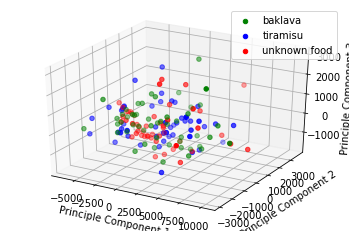

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(projection='3d')


ax1.scatter(xbak, ybak, zbak, color='g', label = 'baklava')
ax1.scatter(xtra, ytra, ztra, color='b', label = 'tiramisu')
ax1.scatter(xrav, yrav, zrav, color='r', label = 'unknown food')


ax1.set_xlabel('Principle Component 1')
ax1.set_ylabel('Principle Component 2')
ax1.set_zlabel('Principle Component 3')

plt.legend()
plt.show()